In [ ]:
import random
import copy
from pathlib import Path
from typing import List, Tuple, Dict
from collections import defaultdict
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import degree, add_self_loops
from torch_geometric.nn import MessagePassing

In [2]:
# Dataset configuration to switch between datasets easily
class DatasetConfig:
    def __init__(self, name, base_path, has_validation=True):
        self.name = name
        self.base_path = Path(base_path)
        self.has_validation = has_validation
        
        self.train_path = self.base_path / "train.txt"
        self.test_path = self.base_path / "test.txt" 
        self.valid_path = self.base_path / "valid.txt" if has_validation else None
    
    def __str__(self):
        return f"Dataset: {self.name} | Path: {self.base_path}"

# Available dataset configurations
DATASETS = {
    'FB15K': DatasetConfig('FB15K', '../FB15K-237.2', has_validation=True),
    # Add more datasets here as needed
}

# Select dataset to use
CURRENT_DATASET = 'FB15K'
config = DATASETS[CURRENT_DATASET]

if config.valid_path:
    print(f"Validation file: {config.valid_path}")

# Check if files exist
for path in [config.train_path, config.test_path, config.valid_path]:
    if path and path.exists():
        print(f"{path}")
    elif path:
        print(f"{path} - File not found!")

Validation file: ..\FB15K-237.2\valid.txt
..\FB15K-237.2\train.txt
..\FB15K-237.2\test.txt
..\FB15K-237.2\valid.txt


In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_dataset(path: Path) -> List[Tuple[str, str, str]]:
    """Load dataset from tab-separated file"""
    data = []
    if not path.exists():
        raise FileNotFoundError(f"Dataset file not found: {path}")
    
    with open(path, "r") as f:
        for line_num, line in enumerate(f, 1):
            try:
                parts = line.strip().split("\t")
                if len(parts) != 3:
                    print(f"Warning: Line {line_num} has {len(parts)} parts, expected 3")
                    continue
                h, r, t = parts
                data.append((h, r, t))
            except Exception as e:
                print(f"Error parsing line {line_num}: {e}")
                continue
    
    print(f"Loaded {len(data)} triples from {path}")
    return data

# Load datasets using the configuration
train_dataset = load_dataset(config.train_path)
test_dataset = load_dataset(config.test_path)
valid_dataset = load_dataset(config.valid_path) if config.valid_path else []

print(f"\nDataset Statistics for {config.name}:")
print(f"Training triples: {len(train_dataset):,}")
print(f"Test triples: {len(test_dataset):,}")
print(f"Validation triples: {len(valid_dataset):,}")

# Build ID maps
entities: set[str] = set()
relations: set[str] = set()
all_data = train_dataset + test_dataset + valid_dataset

for h, r, t in all_data:
    entities.add(h); entities.add(t); relations.add(r)

ent2id: Dict[str, int] = {e: i for i, e in enumerate(sorted(entities))}
rel2id: Dict[str, int] = {r: i for i, r in enumerate(sorted(relations))}
id2ent = {v: k for k, v in ent2id.items()}
id2rel = {v: k for k, v in rel2id.items()}

num_entities = len(ent2id)
num_relations = len(rel2id)
print(f"\nVocabulary Statistics:")
print(f"Entities: {num_entities:,}")
print(f"Relations: {num_relations:,}")

def triples_to_tensor(triples: List[Tuple[str, str, str]]) -> torch.LongTensor:
    """Convert string triples to tensor of IDs"""
    if not triples:
        return torch.empty((0, 3), dtype=torch.long)
    arr = np.array([(ent2id[h], rel2id[r], ent2id[t]) for h, r, t in triples], dtype=np.int64)
    return torch.from_numpy(arr)

# Convert to tensors and move to device
train_triples = triples_to_tensor(train_dataset).to(device)
test_triples = triples_to_tensor(test_dataset).to(device)
valid_triples = triples_to_tensor(valid_dataset).to(device)

print(f"\nTensor shapes:")
print(f"Train: {train_triples.shape}")
print(f"Test: {test_triples.shape}")
print(f"Valid: {valid_triples.shape}")

# Build collapsed undirected graph for LightGCN encoder
print("\nBuilding graph structure...")
edges = []
for h, r, t in train_triples.tolist():
    edges.append((h, t))
    edges.append((t, h))  # Add reverse edges for undirected graph

edge_index = torch.tensor(edges, dtype=torch.long, device=device).t().contiguous()
edge_index, _ = add_self_loops(edge_index, num_nodes=num_entities)

print(f"Graph edges (with self-loops): {edge_index.shape[1]:,}")
print(f"Graph edge_index shape: {tuple(edge_index.shape)}")

Using device: cpu
Loaded 272115 triples from ..\FB15K-237.2\train.txt
Loaded 20466 triples from ..\FB15K-237.2\test.txt
Loaded 17535 triples from ..\FB15K-237.2\valid.txt

Dataset Statistics for FB15K:
Training triples: 272,115
Test triples: 20,466
Validation triples: 17,535

Vocabulary Statistics:
Entities: 14,541
Relations: 237

Tensor shapes:
Train: torch.Size([272115, 3])
Test: torch.Size([20466, 3])
Valid: torch.Size([17535, 3])

Building graph structure...
Graph edges (with self-loops): 558,771
Graph edge_index shape: (2, 558771)


In [4]:
@torch.no_grad()
def batch_scores(z: torch.Tensor, pairs: torch.LongTensor, batch_size: int = 4096) -> torch.Tensor:
    """Calculate scores for pairs in batches to avoid memory issues"""
    scores = []
    for i in range(0, pairs.size(1), batch_size):
        batch = pairs[:, i:i+batch_size]
        s = (z[batch[0]] * z[batch[1]]).sum(dim=1)
        scores.append(s)
    return torch.cat(scores, dim=0)

In [5]:
@torch.no_grad()
def evaluate_ranking_metrics(model, edge_index, test_triples, num_entities, 
                            k_values=[1, 3, 5, 10], batch_size=64, 
                            rel_edge_index=None, edge_type=None):

    model.eval()
    
    # Get entity embeddings
    if rel_edge_index is not None and edge_type is not None:
        # R-LightGCN case
        z = model.encode(rel_edge_index, edge_type)
        use_relations = hasattr(model, 'rel_emb')  # Check if model has relation embeddings
    else:
        # LightGCN case
        z = model.encode(edge_index)
        use_relations = False
    
    all_metrics = {
        'head': {'auc': [], 'ap': [], 'recall': [], 'mr': [], 'mrr': [], **{f'hits@{k}': [] for k in k_values}},
        'tail': {'auc': [], 'ap': [], 'recall': [], 'mr': [], 'mrr': [], **{f'hits@{k}': [] for k in k_values}}
    }
    
    # Process in batches to avoid memory issues
    num_batches = (len(test_triples) + batch_size - 1) // batch_size
    
    for mode in ['head', 'tail']:
        print(f"Evaluating {mode} corruption...")
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(test_triples))
            batch_triples = test_triples[start_idx:end_idx]
            
            if len(batch_triples) == 0:
                continue
                
            # For each triple in batch, rank against all entities
            for triple in batch_triples:
                h, r, t = triple.cpu().tolist()
                
                if mode == 'head':
                    target_entity = h
                    if use_relations:
                        # R-LightGCN: Use relation-aware scoring
                        all_heads = torch.arange(num_entities, device=device)
                        all_pairs = torch.stack([all_heads, torch.full_like(all_heads, t)], dim=0)
                        rel_types = torch.full((num_entities,), r, device=device)
                        scores = model.decode(z, all_pairs, rel_types)
                    else:
                        # LightGCN: Simple dot product
                        scores = (z * z[t]).sum(dim=1)
                else:
                    target_entity = t
                    if use_relations:
                        # R-LightGCN: Use relation-aware scoring
                        all_tails = torch.arange(num_entities, device=device)
                        all_pairs = torch.stack([torch.full_like(all_tails, h), all_tails], dim=0)
                        rel_types = torch.full((num_entities,), r, device=device)
                        scores = model.decode(z, all_pairs, rel_types)
                    else:
                        # LightGCN: Simple dot product
                        scores = (z[h] * z).sum(dim=1)
                
                # Get rankings (higher scores = better ranks)
                _, sorted_indices = torch.sort(scores, descending=True)
                rank = (sorted_indices == target_entity).nonzero(as_tuple=True)[0].item() + 1
                
                # Create binary labels for AUC/AP
                y_true = torch.zeros(num_entities, device=device)
                y_true[target_entity] = 1
                y_score = scores
                
                # Convert to CPU for sklearn
                y_true_cpu = y_true.cpu().numpy()
                y_score_cpu = y_score.cpu().numpy()
                
                # Calculate metrics
                try:
                    auc = roc_auc_score(y_true_cpu, y_score_cpu)
                    ap = average_precision_score(y_true_cpu, y_score_cpu)
                except:
                    auc = 0.5  # Random performance
                    ap = 1.0 / num_entities
                
                # Calculate recall
                y_pred_cpu = (y_score_cpu > np.median(y_score_cpu)).astype(int)
                recall = recall_score(y_true_cpu, y_pred_cpu)       

                mr = rank
                mrr = 1.0 / rank
                
                # Hits@K
                hits_at_k = {}
                for k in k_values:
                    hits_at_k[f'hits@{k}'] = 1.0 if rank <= k else 0.0
                
                # Store metrics
                all_metrics[mode]['auc'].append(auc)
                all_metrics[mode]['ap'].append(ap)
                all_metrics[mode]['recall'].append(recall)
                all_metrics[mode]['mr'].append(mr)
                all_metrics[mode]['mrr'].append(mrr)
                for k in k_values:
                    all_metrics[mode][f'hits@{k}'].append(hits_at_k[f'hits@{k}'])
    
    # Average all metrics
    final_metrics = {}
    for mode in ['head', 'tail']:
        final_metrics[mode] = {}
        for metric_name, values in all_metrics[mode].items():
            if values:  # Check if list is not empty
                final_metrics[mode][metric_name] = np.mean(values)
            else:
                final_metrics[mode][metric_name] = 0.0
    
    return final_metrics

In [6]:
def log_and_track_metrics(epoch, avg_loss, val_ranking_metrics, metrics_tracker, model_name="Model"):
    """
    Utility function to track and log training metrics
    
    Args:
        epoch: Current training epoch
        avg_loss: Average loss for the epoch
        val_ranking_metrics: Dictionary containing head/tail metrics from evaluate_ranking_metrics
        metrics_tracker: MetricsTracker instance to store metrics
        model_name: Name of the model for logging (e.g., "LightGCN", "R-LightGCN")
    """
    # Track ALL metrics
    metrics_dict = {
        'epoch': epoch,
        'loss': avg_loss,
        'val_auc_head': val_ranking_metrics['head']['auc'],
        'val_auc_tail': val_ranking_metrics['tail']['auc'],
        'val_ap_head': val_ranking_metrics['head']['ap'],
        'val_ap_tail': val_ranking_metrics['tail']['ap'],
        'val_mrr_head': val_ranking_metrics['head']['mrr'],
        'val_mrr_tail': val_ranking_metrics['tail']['mrr'],
        'val_mr_head': val_ranking_metrics['head']['mr'],
        'val_mr_tail': val_ranking_metrics['tail']['mr'],
        'val_hits@1_head': val_ranking_metrics['head']['hits@1'],
        'val_hits@1_tail': val_ranking_metrics['tail']['hits@1'],
        'val_hits@10_head': val_ranking_metrics['head']['hits@10'], 
        'val_hits@10_tail': val_ranking_metrics['tail']['hits@10'],
    }
    
    metrics_tracker.add(**metrics_dict)
    
    # Print formatted metrics
    print(f"[{model_name}-COMP] Epoch {epoch:03d} | Loss {avg_loss:.4f}")
    print(f"  AUC (H/T): {val_ranking_metrics['head']['auc']:.4f}/{val_ranking_metrics['tail']['auc']:.4f}")
    print(f"  AP (H/T): {val_ranking_metrics['head']['ap']:.4f}/{val_ranking_metrics['tail']['ap']:.4f}")
    print(f"  MRR (H/T): {val_ranking_metrics['head']['mrr']:.4f}/{val_ranking_metrics['tail']['mrr']:.4f}")
    print(f"  Hits@1 (H/T): {val_ranking_metrics['head']['hits@1']:.4f}/{val_ranking_metrics['tail']['hits@1']:.4f}")
    print(f"  Hits@10 (H/T): {val_ranking_metrics['head']['hits@10']:.4f}/{val_ranking_metrics['tail']['hits@10']:.4f}")
    print(f"  MR (H/T): {val_ranking_metrics['head']['mr']:.4f}/{val_ranking_metrics['tail']['mr']:.4f}")

In [7]:
class MetricsTracker:
    def __init__(self):
        self.metrics = defaultdict(list)
    
    def add(self, epoch, **kwargs):
        self.metrics['epoch'].append(epoch)
        for key, value in kwargs.items():
            self.metrics[key].append(value)
    
    def plot(self, title="Training Metrics"):
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        fig.suptitle(title)
        
        # Loss
        axes[0,0].plot(self.metrics['epoch'], self.metrics['loss'])
        axes[0,0].set_title('Training Loss')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        
        # AUC
        if 'val_auc_head' in self.metrics:
            axes[0,1].plot(self.metrics['epoch'], self.metrics['val_auc_head'], label='Head')
            axes[0,1].plot(self.metrics['epoch'], self.metrics['val_auc_tail'], label='Tail')
            axes[0,1].set_title('Validation AUC')
            axes[0,1].set_xlabel('Epoch')
            axes[0,1].set_ylabel('AUC')
            axes[0,1].legend()
        
        # AP
        if 'val_ap_head' in self.metrics:
            axes[0,2].plot(self.metrics['epoch'], self.metrics['val_ap_head'], label='Head')
            axes[0,2].plot(self.metrics['epoch'], self.metrics['val_ap_tail'], label='Tail')
            axes[0,2].set_title('Validation AP')
            axes[0,2].set_xlabel('Epoch')
            axes[0,2].set_ylabel('AP')
            axes[0,2].legend()
        
        # MRR
        if 'val_mrr_head' in self.metrics:
            axes[1,0].plot(self.metrics['epoch'], self.metrics['val_mrr_head'], label='Head')
            axes[1,0].plot(self.metrics['epoch'], self.metrics['val_mrr_tail'], label='Tail')
            axes[1,0].set_title('Validation MRR')
            axes[1,0].set_xlabel('Epoch')
            axes[1,0].set_ylabel('MRR')
            axes[1,0].legend()
        
        # MR (lower is better)
        if 'val_mr_head' in self.metrics:
            axes[2,0].plot(self.metrics['epoch'], self.metrics['val_mr_head'], label='Head')
            axes[2,0].plot(self.metrics['epoch'], self.metrics['val_mr_tail'], label='Tail')
            axes[2,0].set_title('Validation MR (lower=better)')
            axes[2,0].set_xlabel('Epoch')
            axes[2,0].set_ylabel('MR')
            axes[2,0].legend()

        # Hits@1
        if 'val_hits@1_head' in self.metrics:
            axes[1,1].plot(self.metrics['epoch'], self.metrics['val_hits@1_head'], label='Head')
            axes[1,1].plot(self.metrics['epoch'], self.metrics['val_hits@1_tail'], label='Tail')
            axes[1,1].set_title('Validation Hits@1')
            axes[1,1].set_xlabel('Epoch')
            axes[1,1].set_ylabel('Hits@1')
            axes[1,1].legend()
        
        # Hits@10
        if 'val_hits@10_head' in self.metrics:
            axes[1,2].plot(self.metrics['epoch'], self.metrics['val_hits@10_head'], label='Head')
            axes[1,2].plot(self.metrics['epoch'], self.metrics['val_hits@10_tail'], label='Tail')
            axes[1,2].set_title('Validation Hits@10')
            axes[1,2].set_xlabel('Epoch')
            axes[1,2].set_ylabel('Hits@10')
            axes[1,2].legend()
        
        # Remove unused subplots
        axes[2,1].remove()
        axes[2,2].remove()
        
        plt.tight_layout()
        plt.show()

# Model 1 LightGCN

In [8]:
# -------- LightGCN layer --------
class LightGCNConv(MessagePassing):
    def __init__(self):
        super().__init__(aggr='add')

    # Compute symmetric normalization term D^-0.5*A*D^-0.5 to propagate messages through normalized adjacency
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.clamp(min=1).pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, norm=norm)

    # Scales the neighbor embeddings
    def message(self, x_j: torch.Tensor, norm: torch.Tensor) -> torch.Tensor:
        return norm.view(-1, 1) * x_j

# -------- LightGCN encoder + dot-product decoder --------
class LightGCN(nn.Module):
    # Initialize trainable node embeddings
    def __init__(self, num_nodes: int, emb_dim: int = 64, num_layers: int = 3):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.embedding.weight)
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(num_layers)])
        self.num_layers = num_layers

    def encode(self, edge_index: torch.Tensor) -> torch.Tensor:
        x0 = self.embedding.weight
        out = x0
        x = x0
        # Each layer's output is accumulated and averaged
        for conv in self.convs:
            x = conv(x, edge_index)
            out = out + x
        return out / (self.num_layers + 1)

    # Compute dot product between node embeddings for each edge (positive or negative pair)
    @staticmethod
    def decode(z: torch.Tensor, pairs: torch.LongTensor) -> torch.Tensor:
        # pairs: [2, B] with [src; dst]
        return (z[pairs[0]] * z[pairs[1]]).sum(dim=1)

In [9]:
@torch.no_grad()
def pairs_from_triples(triples: torch.LongTensor) -> torch.LongTensor:
    """
    Convert (h, r, t) -> pairs [2, N] = (h, t) for decoding on collapsed graph.
    """
    return triples[:, [0, 2]].t().contiguous()  # [2, N]

@torch.no_grad()
def negative_sample_heads(triples: torch.LongTensor, num_nodes: int) -> torch.LongTensor:
    """
    Corrupt heads: (h, r, t) -> (h', t)
    Returns pairs [2, N].
    """
    N = triples.size(0)
    neg_h = torch.randint(0, num_nodes, (N,), device=triples.device)
    t = triples[:, 2]
    return torch.stack([neg_h, t], dim=0)

@torch.no_grad()
def negative_sample_tails(triples: torch.LongTensor, num_nodes: int) -> torch.LongTensor:
    """
    Corrupt tails: (h, r, t) -> (h, t')
    Returns pairs [2, N].
    """
    N = triples.size(0)
    h = triples[:, 0]
    neg_t = torch.randint(0, num_nodes, (N,), device=triples.device)
    return torch.stack([h, neg_t], dim=0)


In [10]:
def train_one_epoch_lightgcn(model, triples, optimizer, edge_index, 
                            num_entities, batch_size, shuffle=True):
    """
    Train LightGCN with batching
    """
    model.train()
    
    total_loss = 0.0
    num_batches = 0
    
    # Create batches from training triples
    N = triples.size(0)
    if shuffle:
        indices = torch.randperm(N, device=triples.device)
    else:
        indices = torch.arange(N, device=triples.device)

    for i in range(0, N, batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_triples = triples[batch_indices]
        
        z = model.encode(edge_index)
        
        # Generate positive and negative pairs for this batch
        pos_pairs = pairs_from_triples(batch_triples)
        neg_pairs = negative_sample_heads(batch_triples, num_entities)
        
        # Simple dot-product decoding (no relation types)
        pos_scores = model.decode(z, pos_pairs)
        neg_scores = model.decode(z, neg_pairs)
        
        # Compute loss for this batch
        batch_scores = torch.cat([pos_scores, neg_scores])
        batch_labels = torch.cat([
            torch.ones_like(pos_scores),
            torch.zeros_like(neg_scores)
        ])
        
        loss = F.binary_cross_entropy_with_logits(batch_scores, batch_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

In [11]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True, metric='avg_auc'):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.metric = metric
        self.best_score = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, current_metrics, model):
        # Calculate score based on chosen metric
        if self.metric == 'avg_auc':
            score = (current_metrics['head']['auc'] + current_metrics['tail']['auc']) / 2
        elif self.metric == 'avg_mrr':
            score = (current_metrics['head']['mrr'] + current_metrics['tail']['mrr']) / 2
        elif self.metric == 'avg_hits@1':
            score = (current_metrics['head']['hits@1'] + current_metrics['tail']['hits@1']) / 2
        else:
            score = (current_metrics['head']['auc'] + current_metrics['tail']['auc']) / 2
            
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        else:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(model)
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = copy.deepcopy(model.state_dict())

Starting LightGCN training ...
Max epochs: 100, Early stopping patience: 10


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating head corruption...
Evaluating tail corruption...


  1%|          | 1/100 [00:31<52:29, 31.82s/it]

[LightGCN-COMP] Epoch 001 | Loss 0.6577
  AUC (H/T): 0.8264/0.8876
  AP (H/T): 0.0067/0.0570
  MRR (H/T): 0.0067/0.0570
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.0200/0.1400
  MR (H/T): 2525.2600/1635.8400


  4%|▍         | 4/100 [02:01<48:15, 30.17s/it]

Evaluating head corruption...
Evaluating tail corruption...


  5%|▌         | 5/100 [02:32<48:00, 30.32s/it]

[LightGCN-COMP] Epoch 005 | Loss 0.5261
  AUC (H/T): 0.8657/0.9156
  AP (H/T): 0.0241/0.0354
  MRR (H/T): 0.0241/0.0354
  Hits@1 (H/T): 0.0200/0.0000
  Hits@10 (H/T): 0.0200/0.1200
  MR (H/T): 1953.5000/1228.7600


  9%|▉         | 9/100 [04:30<45:00, 29.68s/it]

Evaluating head corruption...
Evaluating tail corruption...


 10%|█         | 10/100 [05:00<44:38, 29.76s/it]

[LightGCN-COMP] Epoch 010 | Loss 0.5024
  AUC (H/T): 0.8713/0.9102
  AP (H/T): 0.0281/0.0214
  MRR (H/T): 0.0281/0.0214
  Hits@1 (H/T): 0.0200/0.0000
  Hits@10 (H/T): 0.0400/0.0600
  MR (H/T): 1871.8200/1307.1400


 14%|█▍        | 14/100 [06:52<40:54, 28.54s/it]

Evaluating head corruption...
Evaluating tail corruption...


 15%|█▌        | 15/100 [07:22<40:52, 28.85s/it]

[LightGCN-COMP] Epoch 015 | Loss 0.4883
  AUC (H/T): 0.8831/0.9170
  AP (H/T): 0.0304/0.0210
  MRR (H/T): 0.0304/0.0210
  Hits@1 (H/T): 0.0200/0.0000
  Hits@10 (H/T): 0.0400/0.0400
  MR (H/T): 1700.6600/1207.2800


 19%|█▉        | 19/100 [09:18<39:13, 29.05s/it]

Evaluating head corruption...
Evaluating tail corruption...


 20%|██        | 20/100 [09:48<38:59, 29.25s/it]

[LightGCN-COMP] Epoch 020 | Loss 0.4777
  AUC (H/T): 0.8897/0.9192
  AP (H/T): 0.0312/0.0227
  MRR (H/T): 0.0312/0.0227
  Hits@1 (H/T): 0.0200/0.0000
  Hits@10 (H/T): 0.0400/0.0400
  MR (H/T): 1605.0000/1176.3400


 24%|██▍       | 24/100 [11:39<35:39, 28.15s/it]

Evaluating head corruption...
Evaluating tail corruption...


 25%|██▌       | 25/100 [12:08<35:37, 28.50s/it]

[LightGCN-COMP] Epoch 025 | Loss 0.4690
  AUC (H/T): 0.8926/0.9186
  AP (H/T): 0.0338/0.0236
  MRR (H/T): 0.0338/0.0236
  Hits@1 (H/T): 0.0200/0.0000
  Hits@10 (H/T): 0.0400/0.1000
  MR (H/T): 1562.1600/1185.1400


 29%|██▉       | 29/100 [14:00<33:15, 28.10s/it]

Evaluating head corruption...
Evaluating tail corruption...


 30%|███       | 30/100 [14:30<33:16, 28.51s/it]

[LightGCN-COMP] Epoch 030 | Loss 0.4626
  AUC (H/T): 0.8963/0.9224
  AP (H/T): 0.0366/0.0235
  MRR (H/T): 0.0366/0.0235
  Hits@1 (H/T): 0.0200/0.0000
  Hits@10 (H/T): 0.0600/0.0600
  MR (H/T): 1508.6000/1129.0400


 34%|███▍      | 34/100 [16:22<30:53, 28.08s/it]

Evaluating head corruption...
Evaluating tail corruption...


 35%|███▌      | 35/100 [16:51<30:56, 28.56s/it]

[LightGCN-COMP] Epoch 035 | Loss 0.4573
  AUC (H/T): 0.8980/0.9238
  AP (H/T): 0.0379/0.0292
  MRR (H/T): 0.0379/0.0292
  Hits@1 (H/T): 0.0200/0.0000
  Hits@10 (H/T): 0.0600/0.0800
  MR (H/T): 1483.6000/1109.1000


 39%|███▉      | 39/100 [19:14<35:36, 35.02s/it]

Evaluating head corruption...
Evaluating tail corruption...


 40%|████      | 40/100 [19:55<36:42, 36.71s/it]

[LightGCN-COMP] Epoch 040 | Loss 0.4515
  AUC (H/T): 0.9008/0.9252
  AP (H/T): 0.0386/0.0384
  MRR (H/T): 0.0386/0.0384
  Hits@1 (H/T): 0.0200/0.0200
  Hits@10 (H/T): 0.1000/0.0800
  MR (H/T): 1442.8200/1088.4600


 44%|████▍     | 44/100 [22:29<35:13, 37.74s/it]

Evaluating head corruption...
Evaluating tail corruption...


 45%|████▌     | 45/100 [23:09<35:11, 38.40s/it]

[LightGCN-COMP] Epoch 045 | Loss 0.4476
  AUC (H/T): 0.9011/0.9254
  AP (H/T): 0.0377/0.0391
  MRR (H/T): 0.0377/0.0391
  Hits@1 (H/T): 0.0200/0.0200
  Hits@10 (H/T): 0.0800/0.0600
  MR (H/T): 1439.5200/1085.9800


 49%|████▉     | 49/100 [25:40<32:12, 37.89s/it]

Evaluating head corruption...
Evaluating tail corruption...


 50%|█████     | 50/100 [26:19<32:02, 38.46s/it]

[LightGCN-COMP] Epoch 050 | Loss 0.4429
  AUC (H/T): 0.8976/0.9148
  AP (H/T): 0.0348/0.0385
  MRR (H/T): 0.0348/0.0385
  Hits@1 (H/T): 0.0200/0.0200
  Hits@10 (H/T): 0.0800/0.0600
  MR (H/T): 1490.5000/1239.1600


 54%|█████▍    | 54/100 [28:50<28:59, 37.82s/it]

Evaluating head corruption...
Evaluating tail corruption...


 55%|█████▌    | 55/100 [29:30<28:52, 38.50s/it]

[LightGCN-COMP] Epoch 055 | Loss 0.4401
  AUC (H/T): 0.8969/0.9139
  AP (H/T): 0.0257/0.0388
  MRR (H/T): 0.0257/0.0388
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.0600/0.0600
  MR (H/T): 1500.4000/1252.7800


 59%|█████▉    | 59/100 [32:00<25:46, 37.72s/it]

Evaluating head corruption...
Evaluating tail corruption...


 60%|██████    | 60/100 [32:40<25:36, 38.42s/it]

[LightGCN-COMP] Epoch 060 | Loss 0.4366
  AUC (H/T): 0.8968/0.9114
  AP (H/T): 0.0257/0.0389
  MRR (H/T): 0.0257/0.0389
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.0600/0.0600
  MR (H/T): 1502.2200/1289.4800


 64%|██████▍   | 64/100 [35:12<22:48, 38.03s/it]

Evaluating head corruption...
Evaluating tail corruption...


 65%|██████▌   | 65/100 [35:53<22:41, 38.91s/it]

[LightGCN-COMP] Epoch 065 | Loss 0.4338
  AUC (H/T): 0.8932/0.9067
  AP (H/T): 0.0312/0.0412
  MRR (H/T): 0.0312/0.0412
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.0600/0.0400
  MR (H/T): 1553.1800/1357.2400


 69%|██████▉   | 69/100 [38:25<19:47, 38.32s/it]

Evaluating head corruption...
Evaluating tail corruption...


 70%|███████   | 70/100 [39:05<19:24, 38.81s/it]

[LightGCN-COMP] Epoch 070 | Loss 0.4306
  AUC (H/T): 0.8948/0.9047
  AP (H/T): 0.0412/0.0415
  MRR (H/T): 0.0412/0.0415
  Hits@1 (H/T): 0.0200/0.0200
  Hits@10 (H/T): 0.0600/0.0600
  MR (H/T): 1531.0400/1386.9200


 74%|███████▍  | 74/100 [41:38<16:38, 38.41s/it]

Evaluating head corruption...
Evaluating tail corruption...


 75%|███████▌  | 75/100 [42:18<16:10, 38.80s/it]

[LightGCN-COMP] Epoch 075 | Loss 0.4272
  AUC (H/T): 0.8949/0.9008
  AP (H/T): 0.0418/0.0431
  MRR (H/T): 0.0418/0.0431
  Hits@1 (H/T): 0.0200/0.0200
  Hits@10 (H/T): 0.0600/0.0600
  MR (H/T): 1528.8600/1443.4000


 79%|███████▉  | 79/100 [44:48<13:15, 37.87s/it]

Evaluating head corruption...
Evaluating tail corruption...


 80%|████████  | 80/100 [45:28<12:47, 38.39s/it]

[LightGCN-COMP] Epoch 080 | Loss 0.4265
  AUC (H/T): 0.8963/0.9010
  AP (H/T): 0.0288/0.0439
  MRR (H/T): 0.0288/0.0439
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.0600/0.0600
  MR (H/T): 1509.4200/1440.7400


 84%|████████▍ | 84/100 [48:00<10:10, 38.16s/it]

Evaluating head corruption...
Evaluating tail corruption...


 85%|████████▌ | 85/100 [48:40<09:39, 38.65s/it]

[LightGCN-COMP] Epoch 085 | Loss 0.4241
  AUC (H/T): 0.8985/0.9040
  AP (H/T): 0.0290/0.0427
  MRR (H/T): 0.0290/0.0427
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.0600/0.0600
  MR (H/T): 1476.3600/1397.1600


 89%|████████▉ | 89/100 [51:10<06:54, 37.72s/it]

Evaluating head corruption...
Evaluating tail corruption...


 89%|████████▉ | 89/100 [51:50<06:24, 34.95s/it]

[LightGCN-COMP] Epoch 090 | Loss 0.4220
  AUC (H/T): 0.8964/0.8944
  AP (H/T): 0.0373/0.0436
  MRR (H/T): 0.0373/0.0436
  Hits@1 (H/T): 0.0200/0.0200
  Hits@10 (H/T): 0.0600/0.0600
  MR (H/T): 1506.6400/1536.0800
Early stopping triggered at epoch 90
Best AUC: 0.9130

LightGCN training completed!


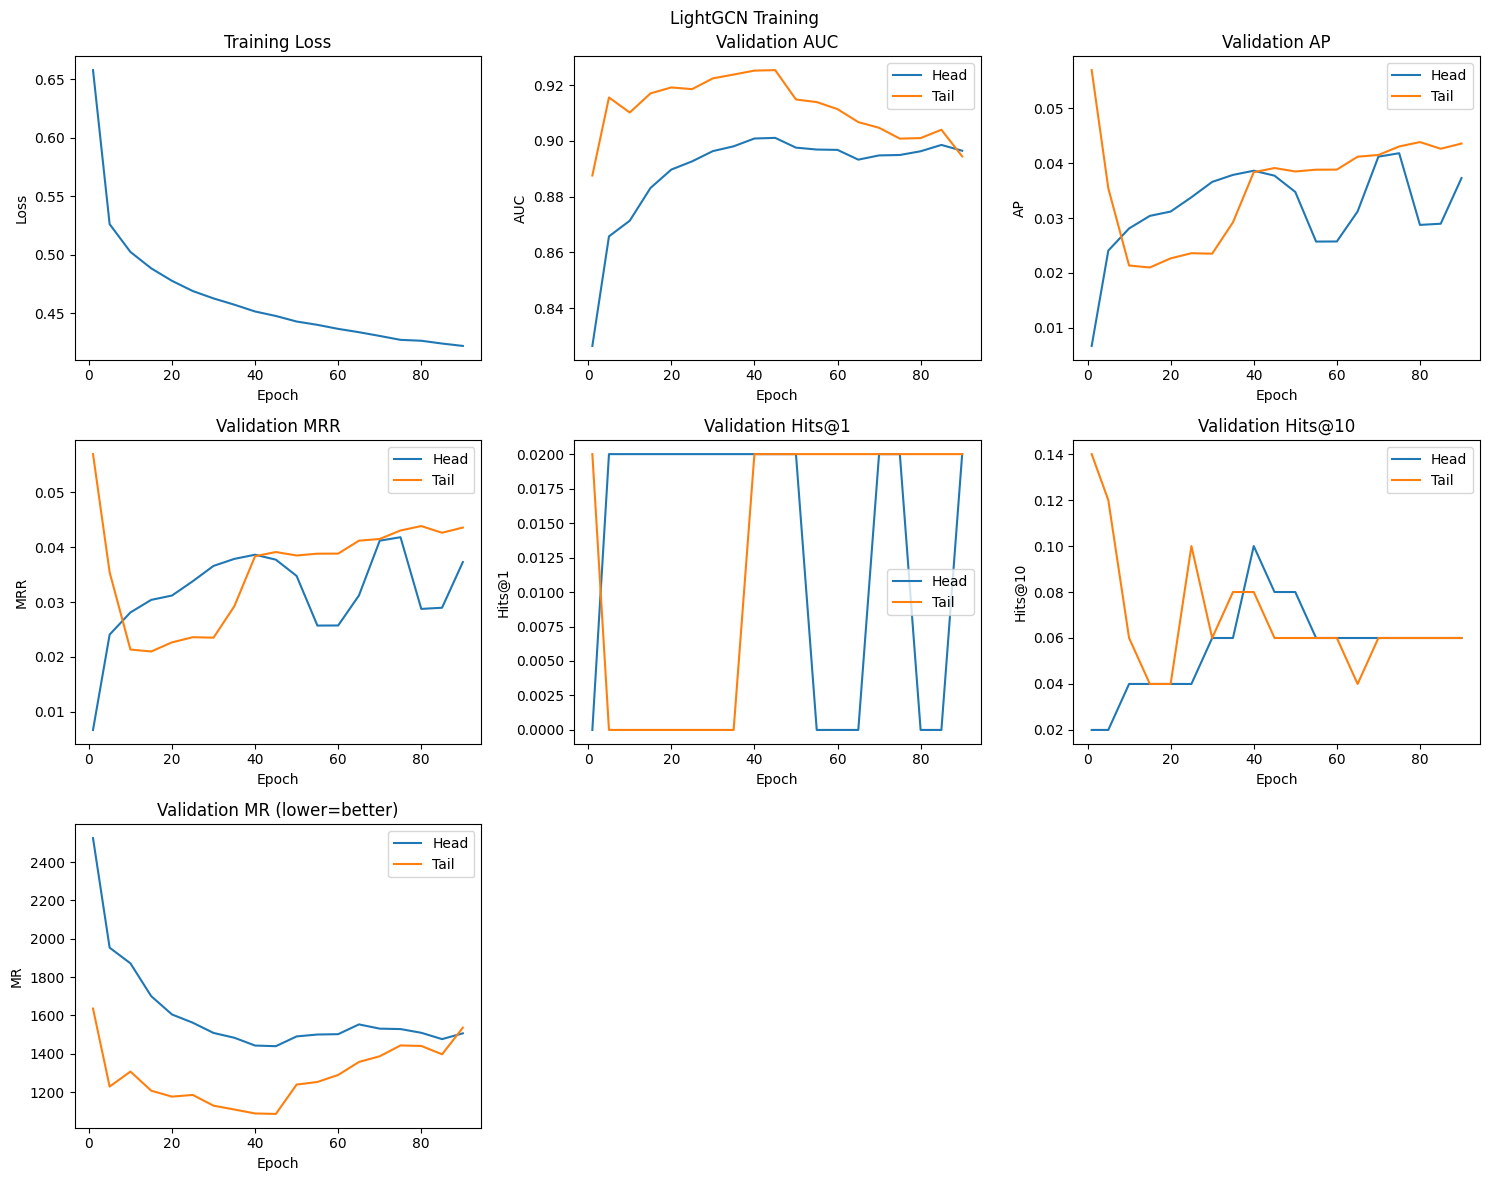

Evaluating head corruption...
Evaluating tail corruption...

[LightGCN with Shuffled Triples][TEST RESULTS]
AUC (H/T): 0.9196/0.9063
MRR (H/T): 0.0547/0.0244
Hits@1 (H/T): 0.0200/0.0000
Hits@10 (H/T): 0.1400/0.0500
MR (H/T): 1170.7/1363.8


In [12]:
lr = 1e-3
epochs = 100
emb_dim = 64
num_layers = 3
eval_every = 5
batch_size = 2048
patience = 10

# Initialize tracking with comprehensive metrics
lightgcn_metrics_tracker = MetricsTracker()
lightgcn_early_stopping = EarlyStopping(patience=patience, min_delta=0.001, metric='avg_auc')

# Create new model for comprehensive training
lightgcn_3 = LightGCN(num_nodes=num_entities, emb_dim=emb_dim, num_layers=num_layers).to(device)
opt_comprehensive = torch.optim.Adam(lightgcn_3.parameters(), lr=lr)

print("Starting LightGCN training ...")
print(f"Max epochs: {epochs}, Early stopping patience: {patience}")

for epoch in tqdm(range(1, epochs + 1)):
    avg_loss = train_one_epoch_lightgcn(
        lightgcn_3, train_triples, opt_comprehensive, 
        edge_index, num_entities, 
        batch_size, True
    )

    # Comprehensive evaluation every epoch (using small subset for speed)
    if epoch % eval_every == 0 or epoch == 1:
        lightgcn_3.eval()
        
        # Use small subset for comprehensive metrics to avoid long computation
        val_subset = valid_triples[:50] if len(valid_triples) > 50 else valid_triples
        
        # Get comprehensive ranking metrics
        lightgcn_ranking_metrics = evaluate_ranking_metrics(
            lightgcn_3, edge_index, val_subset, num_entities, 
            k_values=[1, 3, 5, 10], batch_size=10
        )
        
        log_and_track_metrics(
            epoch=epoch,
            avg_loss=avg_loss,
            val_ranking_metrics=lightgcn_ranking_metrics,
            metrics_tracker=lightgcn_metrics_tracker,
            model_name="LightGCN"
        )

        if lightgcn_early_stopping(lightgcn_ranking_metrics, lightgcn_3):
            print(f"Early stopping triggered at epoch {epoch}")
            print(f"Best AUC: {lightgcn_early_stopping.best_score:.4f}")
            break

print("\nLightGCN training completed!")

# Plot all metrics
lightgcn_metrics_tracker.plot("LightGCN Training")

# Final comprehensive test evaluation
lightgcn_3.eval()
test_subset = test_triples[:100]
lightgcn_final_test_metrics = evaluate_ranking_metrics(
    lightgcn_3, edge_index, test_subset, num_entities, 
    k_values=[1, 3, 5, 10], batch_size=20
)

print(f"\n[LightGCN with Shuffled Triples][TEST RESULTS]")
print(f"AUC (H/T): {lightgcn_final_test_metrics['head']['auc']:.4f}/{lightgcn_final_test_metrics['tail']['auc']:.4f}")
print(f"MRR (H/T): {lightgcn_final_test_metrics['head']['mrr']:.4f}/{lightgcn_final_test_metrics['tail']['mrr']:.4f}")
print(f"Hits@1 (H/T): {lightgcn_final_test_metrics['head']['hits@1']:.4f}/{lightgcn_final_test_metrics['tail']['hits@1']:.4f}")
print(f"Hits@10 (H/T): {lightgcn_final_test_metrics['head']['hits@10']:.4f}/{lightgcn_final_test_metrics['tail']['hits@10']:.4f}")
print(f"MR (H/T): {lightgcn_final_test_metrics['head']['mr']:.1f}/{lightgcn_final_test_metrics['tail']['mr']:.1f}")

# Model 2 R-LightGCN

In [13]:
# -------- R-LightGCN Layer --------
class RLightGCNConv(MessagePassing):
    def __init__(self, num_relations: int, emb_dim: int, rel_emb: nn.Embedding):
        super().__init__(aggr='add')
        self.rel_emb = rel_emb   # share the same relation embedding from the main model
        self.emb_dim = emb_dim

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_type: torch.LongTensor) -> torch.Tensor:
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.clamp(min=1).pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, edge_type=edge_type, norm=norm)

    def message(self, x_j: torch.Tensor, edge_type: torch.LongTensor, norm: torch.Tensor) -> torch.Tensor:
        # Each relation type has its own embedding vector
        rel_vec = self.rel_emb(edge_type)           # [num_edges, emb_dim]
        return norm.view(-1, 1) * (x_j * rel_vec)   # elementwise scaling by relation embedding


# -------- R-LightGCN Model --------
class RLightGCN(nn.Module):
    def __init__(self, num_nodes: int, num_relations: int, emb_dim: int = 64, num_layers: int = 3):
        super().__init__()

        # Node embeddings
        self.embedding = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.embedding.weight)
        
        # Relation embeddings (shared across layers)
        self.rel_emb = nn.Embedding(num_relations, emb_dim)
        nn.init.xavier_uniform_(self.rel_emb.weight)

        # Pass relation embedding into each conv layer
        self.convs = nn.ModuleList([
            RLightGCNConv(num_relations, emb_dim, self.rel_emb)
            for _ in range(num_layers)
        ])
        self.num_layers = num_layers

    def encode(self, edge_index: torch.Tensor, edge_type: torch.LongTensor) -> torch.Tensor:
        x0 = self.embedding.weight
        out = x0
        x = x0
        for conv in self.convs:
            x = conv(x, edge_index, edge_type)
            out = out + x
        return out / (self.num_layers + 1)

    def decode(self, z: torch.Tensor, pairs: torch.LongTensor, rel_type: torch.LongTensor) -> torch.Tensor:
        head, tail = pairs
        r_emb = self.rel_emb(rel_type)
        return (z[head] * r_emb * z[tail]).sum(dim=1)

    def forward(self, edge_index, edge_type, pairs, rel_type):
        z = self.encode(edge_index, edge_type)
        return self.decode(z, pairs, rel_type)


In [14]:
def train_one_epoch_r_lightgcn(model, triples, optimizer, rel_edge_index, edge_type, 
                               num_entities, batch_size=2048, shuffle=True):
    """
    Train R-LightGCN with batching
    """
    model.train()
    
    total_loss = 0.0
    num_batches = 0
    
    # Create batches from shuffled triples
    N = triples.size(0)

    if shuffle:
        indices = torch.randperm(N, device=triples.device)
    else:
        indices = torch.arange(N, device=triples.device)
    
    for i in range(0, N, batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_triples = triples[batch_indices]
        
        z = model.encode(rel_edge_index, edge_type)

        # Generate positive and negative pairs for this batch
        pos_pairs = pairs_from_triples(batch_triples)
        neg_pairs = negative_sample_heads(batch_triples, num_entities)
        
        # Get relation types for positive and negative pairs
        pos_rel_type = batch_triples[:, 1]
        neg_rel_type = pos_rel_type.clone()  # Same relations for negatives
        
        # Decode scores
        pos_scores = model.decode(z, pos_pairs, pos_rel_type)
        neg_scores = model.decode(z, neg_pairs, neg_rel_type)
        
        # Compute loss for this batch
        batch_scores = torch.cat([pos_scores, neg_scores])
        batch_labels = torch.cat([
            torch.ones_like(pos_scores),
            torch.zeros_like(neg_scores)
        ])
        
        loss = F.binary_cross_entropy_with_logits(batch_scores, batch_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

Starting R-LightGCN training with enhanced features...
Max epochs: 100, Early stopping patience: 10


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating head corruption...
Evaluating tail corruption...


  1%|          | 1/100 [01:40<2:45:48, 100.49s/it]

[R-LightGCN-COMP] Epoch 001 | Loss 0.6931
  AUC (H/T): 0.6061/0.6023
  AP (H/T): 0.0014/0.0049
  MRR (H/T): 0.0014/0.0049
  Hits@1 (H/T): 0.0000/0.0000
  Hits@10 (H/T): 0.0000/0.0200
  MR (H/T): 5727.7200/5783.7200


  4%|▍         | 4/100 [06:29<2:34:59, 96.87s/it] 

Evaluating head corruption...
Evaluating tail corruption...


  5%|▌         | 5/100 [08:09<2:34:57, 97.87s/it]

[R-LightGCN-COMP] Epoch 005 | Loss 0.4719
  AUC (H/T): 0.9357/0.9562
  AP (H/T): 0.0528/0.2938
  MRR (H/T): 0.0528/0.2938
  Hits@1 (H/T): 0.0200/0.2200
  Hits@10 (H/T): 0.1000/0.4200
  MR (H/T): 936.6400/638.0800


  9%|▉         | 9/100 [14:32<2:25:59, 96.25s/it]

Evaluating head corruption...
Evaluating tail corruption...


 10%|█         | 10/100 [16:11<2:25:47, 97.19s/it]

[R-LightGCN-COMP] Epoch 010 | Loss 0.4149
  AUC (H/T): 0.9569/0.9811
  AP (H/T): 0.0670/0.2965
  MRR (H/T): 0.0670/0.2965
  Hits@1 (H/T): 0.0200/0.2200
  Hits@10 (H/T): 0.1400/0.4000
  MR (H/T): 627.4000/275.3000


 14%|█▍        | 14/100 [22:35<2:18:09, 96.39s/it]

Evaluating head corruption...
Evaluating tail corruption...


 15%|█▌        | 15/100 [24:14<2:17:39, 97.18s/it]

[R-LightGCN-COMP] Epoch 015 | Loss 0.3820
  AUC (H/T): 0.9560/0.9843
  AP (H/T): 0.0799/0.2509
  MRR (H/T): 0.0799/0.2509
  Hits@1 (H/T): 0.0400/0.1600
  Hits@10 (H/T): 0.1600/0.4200
  MR (H/T): 640.6200/228.7800


 19%|█▉        | 19/100 [30:39<2:10:09, 96.41s/it]

Evaluating head corruption...
Evaluating tail corruption...


 20%|██        | 20/100 [32:18<2:09:33, 97.17s/it]

[R-LightGCN-COMP] Epoch 020 | Loss 0.3508
  AUC (H/T): 0.9473/0.9619
  AP (H/T): 0.0730/0.2122
  MRR (H/T): 0.0730/0.2122
  Hits@1 (H/T): 0.0400/0.1600
  Hits@10 (H/T): 0.1600/0.3600
  MR (H/T): 766.8200/554.3200


 24%|██▍       | 24/100 [38:42<2:02:13, 96.49s/it]

Evaluating head corruption...
Evaluating tail corruption...


 25%|██▌       | 25/100 [40:21<2:01:31, 97.22s/it]

[R-LightGCN-COMP] Epoch 025 | Loss 0.3206
  AUC (H/T): 0.9384/0.9305
  AP (H/T): 0.0669/0.1535
  MRR (H/T): 0.0669/0.1535
  Hits@1 (H/T): 0.0400/0.1200
  Hits@10 (H/T): 0.1400/0.2400
  MR (H/T): 896.0600/1011.6400


 29%|██▉       | 29/100 [46:46<1:54:09, 96.48s/it]

Evaluating head corruption...
Evaluating tail corruption...


 30%|███       | 30/100 [48:25<1:53:28, 97.26s/it]

[R-LightGCN-COMP] Epoch 030 | Loss 0.2971
  AUC (H/T): 0.9334/0.9011
  AP (H/T): 0.0655/0.0858
  MRR (H/T): 0.0655/0.0858
  Hits@1 (H/T): 0.0400/0.0400
  Hits@10 (H/T): 0.1400/0.1600
  MR (H/T): 969.9200/1439.4000


 34%|███▍      | 34/100 [54:49<1:45:44, 96.14s/it]

Evaluating head corruption...
Evaluating tail corruption...


 35%|███▌      | 35/100 [56:28<1:45:09, 97.07s/it]

[R-LightGCN-COMP] Epoch 035 | Loss 0.2765
  AUC (H/T): 0.9252/0.8689
  AP (H/T): 0.0645/0.0525
  MRR (H/T): 0.0645/0.0525
  Hits@1 (H/T): 0.0400/0.0200
  Hits@10 (H/T): 0.1200/0.0800
  MR (H/T): 1088.7200/1907.3800


 39%|███▉      | 39/100 [1:02:56<1:38:47, 97.18s/it]

Evaluating head corruption...
Evaluating tail corruption...


 40%|████      | 40/100 [1:04:34<1:37:33, 97.56s/it]

[R-LightGCN-COMP] Epoch 040 | Loss 0.2564
  AUC (H/T): 0.9247/0.8579
  AP (H/T): 0.0632/0.0341
  MRR (H/T): 0.0632/0.0341
  Hits@1 (H/T): 0.0400/0.0000
  Hits@10 (H/T): 0.1000/0.0600
  MR (H/T): 1095.9200/2067.1600


 44%|████▍     | 44/100 [1:11:00<1:30:09, 96.59s/it]

Evaluating head corruption...
Evaluating tail corruption...


 45%|████▌     | 45/100 [1:12:38<1:29:06, 97.21s/it]

[R-LightGCN-COMP] Epoch 045 | Loss 0.2404
  AUC (H/T): 0.9215/0.8440
  AP (H/T): 0.0621/0.0197
  MRR (H/T): 0.0621/0.0197
  Hits@1 (H/T): 0.0400/0.0000
  Hits@10 (H/T): 0.1000/0.0600
  MR (H/T): 1142.3800/2268.7400


 49%|████▉     | 49/100 [1:19:02<1:21:43, 96.14s/it]

Evaluating head corruption...
Evaluating tail corruption...


 50%|█████     | 50/100 [1:20:40<1:20:41, 96.83s/it]

[R-LightGCN-COMP] Epoch 050 | Loss 0.2272
  AUC (H/T): 0.9197/0.8232
  AP (H/T): 0.0618/0.0141
  MRR (H/T): 0.0618/0.0141
  Hits@1 (H/T): 0.0400/0.0000
  Hits@10 (H/T): 0.1200/0.0800
  MR (H/T): 1168.1000/2571.9800


 54%|█████▍    | 54/100 [1:27:04<1:13:37, 96.04s/it]

Evaluating head corruption...
Evaluating tail corruption...


 55%|█████▌    | 55/100 [1:28:43<1:12:48, 97.09s/it]

[R-LightGCN-COMP] Epoch 055 | Loss 0.2121
  AUC (H/T): 0.9190/0.8037
  AP (H/T): 0.0617/0.0091
  MRR (H/T): 0.0617/0.0091
  Hits@1 (H/T): 0.0400/0.0000
  Hits@10 (H/T): 0.1200/0.0200
  MR (H/T): 1178.9200/2855.7400


 59%|█████▉    | 59/100 [1:35:07<1:05:50, 96.36s/it]

Evaluating head corruption...
Evaluating tail corruption...


 60%|██████    | 60/100 [1:36:46<1:04:51, 97.29s/it]

[R-LightGCN-COMP] Epoch 060 | Loss 0.2028
  AUC (H/T): 0.9202/0.7926
  AP (H/T): 0.0619/0.0078
  MRR (H/T): 0.0619/0.0078
  Hits@1 (H/T): 0.0400/0.0000
  Hits@10 (H/T): 0.1200/0.0200
  MR (H/T): 1160.9400/3016.4800


 64%|██████▍   | 64/100 [1:43:11<57:47, 96.33s/it]  

Evaluating head corruption...
Evaluating tail corruption...


 64%|██████▍   | 64/100 [1:44:50<58:58, 98.30s/it]

[R-LightGCN-COMP] Epoch 065 | Loss 0.1913
  AUC (H/T): 0.9204/0.7790
  AP (H/T): 0.0626/0.0059
  MRR (H/T): 0.0626/0.0059
  Hits@1 (H/T): 0.0400/0.0000
  Hits@10 (H/T): 0.1200/0.0000
  MR (H/T): 1157.8200/3213.7800
Early stopping triggered at epoch 65
Best AUC: 0.9702
R-LightGCN training completed!


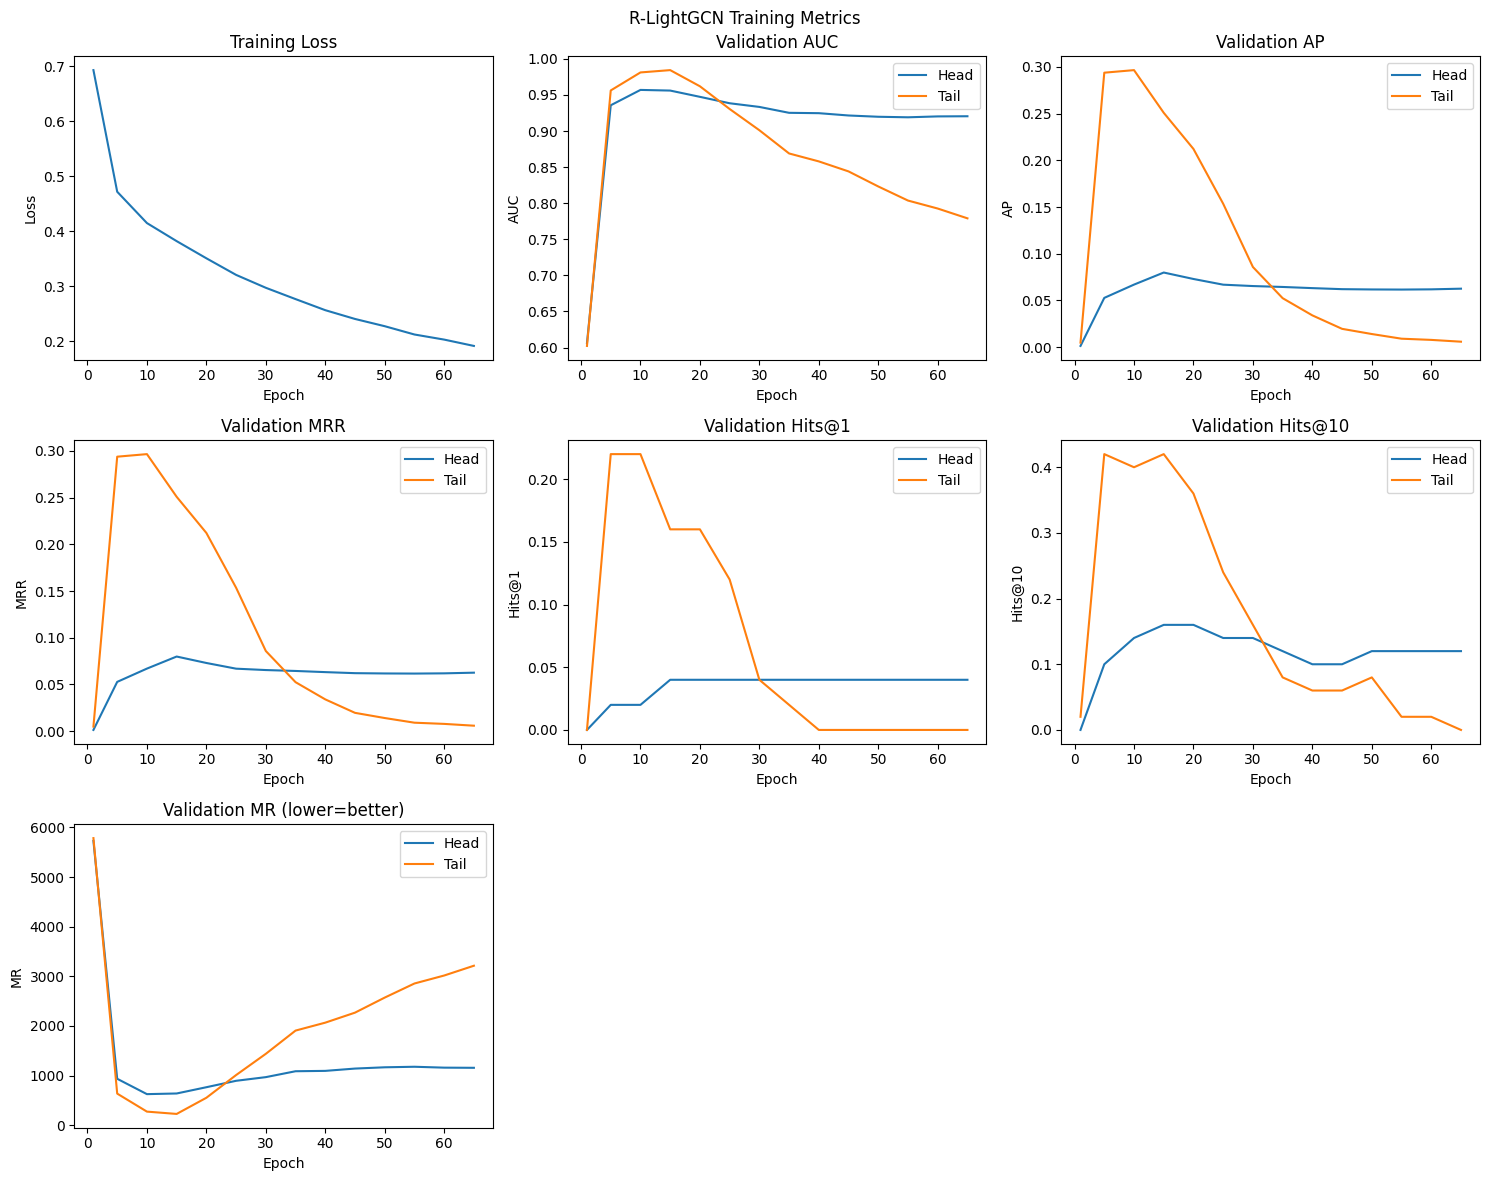

Evaluating head corruption...
Evaluating tail corruption...

[R-LightGCN with Shuffled Triples][TEST RESULTS]
AUC (H/T): 0.9734/0.9714
MRR (H/T): 0.1139/0.1758
Hits@1 (H/T): 0.0700/0.1100
Hits@10 (H/T): 0.1900/0.3000
MR (H/T): 388.3/416.3


In [15]:
# Build relation-aware edge_index and edge_type (with reverse edges)
rel_edges = []
rel_types = []

for h, r, t in train_triples.tolist():
    rel_edges.append((h, t)); rel_types.append(r)
    rel_edges.append((t, h)); rel_types.append(r)  # add reverse edge with same relation

rel_edge_index = torch.tensor(rel_edges, dtype=torch.long, device=device).t().contiguous()
edge_type = torch.tensor(rel_types, dtype=torch.long, device=device)

# Add self-loops with a new relation id
self_loop_edges = torch.arange(num_entities, device=device)
self_loop_edges = torch.stack([self_loop_edges, self_loop_edges], dim=0)  # [2, N]
rel_edge_index = torch.cat([rel_edge_index, self_loop_edges], dim=1)

self_loop_types = torch.full((num_entities,), num_relations, dtype=torch.long, device=device)
edge_type = torch.cat([edge_type, self_loop_types], dim=0)

# update relation count
num_relations_with_loops = num_relations + 1

# Training parameters
lr = 1e-3
epochs = 100
emb_dim = 64
num_layers = 3
eval_every = 5
patience = 10
batch_size = 2048

# Initialize tracking for R-LightGCN
r_metrics_tracker = MetricsTracker()
r_early_stopping = EarlyStopping(patience=patience, min_delta=0.001, metric='avg_auc')

r_lightgcn_3 = RLightGCN(
    num_nodes=num_entities,
    num_relations=num_relations_with_loops,
    emb_dim=emb_dim,
    num_layers=num_layers
).to(device)

ropt = torch.optim.Adam(r_lightgcn_3.parameters(), lr=lr)

print("Starting R-LightGCN training with enhanced features...")
print(f"Max epochs: {epochs}, Early stopping patience: {patience}")

for epoch in tqdm(range(1, epochs + 1)):    
    # Train with batching
    avg_loss = train_one_epoch_r_lightgcn(
        r_lightgcn_3, train_triples, ropt, 
        rel_edge_index, edge_type, num_entities, 
        batch_size, True
    )

    # Evaluation and metrics tracking
    if epoch % eval_every == 0 or epoch == 1:
        r_lightgcn_3.eval()

            # Use small subset for comprehensive metrics to avoid long computation
        val_subset = valid_triples[:50] if len(valid_triples) > 50 else valid_triples
        
        # Get comprehensive ranking metrics
        r_ranking_metrics = evaluate_ranking_metrics(
            r_lightgcn_3, None, val_subset, num_entities, 
            k_values=[1, 3, 5, 10], batch_size=10,
            rel_edge_index=rel_edge_index, edge_type=edge_type
        )

        log_and_track_metrics(
            epoch=epoch,
            avg_loss=avg_loss,
            val_ranking_metrics=r_ranking_metrics,
            metrics_tracker=r_metrics_tracker,
            model_name="R-LightGCN"
        )

        if r_early_stopping(r_ranking_metrics, r_lightgcn_3):
            print(f"Early stopping triggered at epoch {epoch}")
            print(f"Best AUC: {r_early_stopping.best_score:.4f}")
            break

print("R-LightGCN training completed!")

# Plot training metrics
r_metrics_tracker.plot("R-LightGCN Training Metrics")

# Final comprehensive test evaluation
r_lightgcn_3.eval()
test_subset = test_triples[:100]
r_final_test_metrics = evaluate_ranking_metrics(
    r_lightgcn_3, None, test_subset, num_entities, 
    k_values=[1, 3, 5, 10], batch_size=20,
    rel_edge_index=rel_edge_index, edge_type=edge_type
)

print(f"\n[R-LightGCN with Shuffled Triples][TEST RESULTS]")
print(f"AUC (H/T): {r_final_test_metrics['head']['auc']:.4f}/{r_final_test_metrics['tail']['auc']:.4f}")
print(f"MRR (H/T): {r_final_test_metrics['head']['mrr']:.4f}/{r_final_test_metrics['tail']['mrr']:.4f}")
print(f"Hits@1 (H/T): {r_final_test_metrics['head']['hits@1']:.4f}/{r_final_test_metrics['tail']['hits@1']:.4f}")
print(f"Hits@10 (H/T): {r_final_test_metrics['head']['hits@10']:.4f}/{r_final_test_metrics['tail']['hits@10']:.4f}")
print(f"MR (H/T): {r_final_test_metrics['head']['mr']:.1f}/{r_final_test_metrics['tail']['mr']:.1f}")

# Save Model

In [16]:
def print_training_history(metrics_tracker, model_name, early_stopping=None):
    """
    Print a formatted training history summary similar to GAT output
    
    Args:
        metrics_tracker: MetricsTracker instance with training history
        model_name: Name of the model (e.g., "LightGCN", "R-LightGCN")
        early_stopping: EarlyStopping instance (optional)
    """
    output_lines = []
    
    output_lines.append(f"\n{model_name} Training History")
    output_lines.append("=" * 60)
    output_lines.append("")
    
    # Get best validation AUC and corresponding epoch
    epochs = metrics_tracker.metrics['epoch']
    auc_head = metrics_tracker.metrics['val_auc_head']
    auc_tail = metrics_tracker.metrics['val_auc_tail']
    avg_auc = [(h + t) / 2 for h, t in zip(auc_head, auc_tail)]
    
    best_auc = max(avg_auc)
    best_epoch = epochs[avg_auc.index(best_auc)]
    total_epochs = len(epochs)
    
    output_lines.append(f"Best Validation AUC: {best_auc:.4f}")
    output_lines.append(f"Total Epochs Trained: {total_epochs}")
    if early_stopping and hasattr(early_stopping, 'best_score'):
        output_lines.append(f"Early Stopping Best Score: {early_stopping.best_score:.4f}")
    output_lines.append("")
    
    # Print table header
    output_lines.append("-" * 60)
    output_lines.append(f"{'Epoch':<8} {'Train Loss':<15} {'Val AUC':<15} {'Val Hits@10':<15}")
    output_lines.append("-" * 60)
    
    # Print each epoch's metrics
    for i, epoch in enumerate(epochs):
        train_loss = metrics_tracker.metrics['loss'][i]
        val_auc = avg_auc[i]
        val_hits10 = (metrics_tracker.metrics['val_hits@10_head'][i] + 
                      metrics_tracker.metrics['val_hits@10_tail'][i]) / 2
        
        output_lines.append(f"{epoch:<8} {train_loss:<15.4f} {val_auc:<15.4f} {val_hits10:<15.4f}")
    
    output_lines.append("")
    
    # Print to console
    for line in output_lines:
        print(line)
    
    # Return lines for saving to file
    return output_lines


In [ ]:
# Create metadata
metadata = {
    "timestamp": datetime.now().isoformat(),
    "dataset": "FB15K",
    "num_entities": num_entities,
    "num_relations": num_relations,
    "emb_dim": emb_dim,
    "num_layers": num_layers,
    "training_epochs": epochs,
    "early_stopping_patience": patience,
    "lr": lr
}

# Collect all output for text file
all_output_lines = []
all_output_lines.append(f"Model Training Results - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
all_output_lines.append("=" * 80)
all_output_lines.append("")

# Print and collect LightGCN training history
lightgcn_history = print_training_history(lightgcn_metrics_tracker, "LightGCN", lightgcn_early_stopping)
all_output_lines.extend(lightgcn_history)

# Save LightGCN
lightgcn_save_dict = {
    "model_state_dict": lightgcn_3.state_dict(),
    "optimizer_state_dict": opt_comprehensive.state_dict(),
    "metadata": metadata,
    "training_metrics": dict(lightgcn_metrics_tracker.metrics),
    "final_test_results": {
        "head_auc": lightgcn_final_test_metrics['head']['auc'],
        "tail_auc": lightgcn_final_test_metrics['tail']['auc'],
        "head_ap": lightgcn_final_test_metrics['head']['ap'],
        "tail_ap": lightgcn_final_test_metrics['tail']['ap'],
        "head_mrr": lightgcn_final_test_metrics['head']['mrr'],
        "tail_mrr": lightgcn_final_test_metrics['tail']['mrr'],
        "head_hits@1": lightgcn_final_test_metrics['head']['hits@1'],
        "tail_hits@1": lightgcn_final_test_metrics['tail']['hits@1'],
        "head_hits@10": lightgcn_final_test_metrics['head']['hits@10'],
        "tail_hits@10": lightgcn_final_test_metrics['tail']['hits@10'],
        "head_mr": lightgcn_final_test_metrics['head']['mr'],
        "tail_mr": lightgcn_final_test_metrics['tail']['mr']
    }
}
torch.save(lightgcn_save_dict, "lightgcn_fb15k.pt")

# Check for R-LightGCN and save if it exists
if 'r_lightgcn_3' in locals() and 'ropt' in locals() and 'r_metrics_tracker' in locals():
    # Print and collect R-LightGCN training history
    r_lightgcn_history = print_training_history(r_metrics_tracker, "R-LightGCN", r_early_stopping)
    all_output_lines.extend(r_lightgcn_history)
    
    # Get final test results for R-LightGCN using r_lightgcn_3 (the current model)
    r_lightgcn_3.eval()
    test_subset = test_triples[:100]
    r_final_test_metrics = evaluate_ranking_metrics(
        r_lightgcn_3, None, test_subset, num_entities, 
        k_values=[1, 3, 5, 10], batch_size=20,
        rel_edge_index=rel_edge_index, edge_type=edge_type
    )
    
    rlightgcn_metadata = metadata.copy()
    rlightgcn_metadata["num_relations_with_loops"] = num_relations_with_loops

    rlightgcn_save_dict = {
        "model_state_dict": r_lightgcn_3.state_dict(),
        "optimizer_state_dict": ropt.state_dict(),
        "metadata": rlightgcn_metadata,
        "training_metrics": dict(r_metrics_tracker.metrics),
        "final_test_results": {
            "head_auc": r_final_test_metrics['head']['auc'],
            "tail_auc": r_final_test_metrics['tail']['auc'],
            "head_ap": r_final_test_metrics['head']['ap'],
            "tail_ap": r_final_test_metrics['tail']['ap'],
            "head_mrr": r_final_test_metrics['head']['mrr'],
            "tail_mrr": r_final_test_metrics['tail']['mrr'],
            "head_hits@1": r_final_test_metrics['head']['hits@1'],
            "tail_hits@1": r_final_test_metrics['tail']['hits@1'],
            "head_hits@10": r_final_test_metrics['head']['hits@10'],
            "tail_hits@10": r_final_test_metrics['tail']['hits@10'],
            "head_mr": r_final_test_metrics['head']['mr'],
            "tail_mr": r_final_test_metrics['tail']['mr']
        }
    }
    torch.save(rlightgcn_save_dict, "rlightgcn_fb15k.pt")
    
    # Add final test results to output
    all_output_lines.append("\nFINAL TEST RESULTS")
    all_output_lines.append("=" * 40)
    all_output_lines.append("")
    all_output_lines.append("[LightGCN with Shuffled Triples]")
    all_output_lines.append(f"AUC (H/T): {lightgcn_final_test_metrics['head']['auc']:.4f}/{lightgcn_final_test_metrics['tail']['auc']:.4f}")
    all_output_lines.append(f"MRR (H/T): {lightgcn_final_test_metrics['head']['mrr']:.4f}/{lightgcn_final_test_metrics['tail']['mrr']:.4f}")
    all_output_lines.append(f"Hits@1 (H/T): {lightgcn_final_test_metrics['head']['hits@1']:.4f}/{lightgcn_final_test_metrics['tail']['hits@1']:.4f}")
    all_output_lines.append(f"Hits@10 (H/T): {lightgcn_final_test_metrics['head']['hits@10']:.4f}/{lightgcn_final_test_metrics['tail']['hits@10']:.4f}")
    all_output_lines.append(f"MR (H/T): {lightgcn_final_test_metrics['head']['mr']:.1f}/{lightgcn_final_test_metrics['tail']['mr']:.1f}")
    all_output_lines.append("")
    all_output_lines.append("[R-LightGCN with Shuffled Triples]")
    all_output_lines.append(f"AUC (H/T): {r_final_test_metrics['head']['auc']:.4f}/{r_final_test_metrics['tail']['auc']:.4f}")
    all_output_lines.append(f"MRR (H/T): {r_final_test_metrics['head']['mrr']:.4f}/{r_final_test_metrics['tail']['mrr']:.4f}")
    all_output_lines.append(f"Hits@1 (H/T): {r_final_test_metrics['head']['hits@1']:.4f}/{r_final_test_metrics['tail']['hits@1']:.4f}")
    all_output_lines.append(f"Hits@10 (H/T): {r_final_test_metrics['head']['hits@10']:.4f}/{r_final_test_metrics['tail']['hits@10']:.4f}")
    all_output_lines.append(f"MR (H/T): {r_final_test_metrics['head']['mr']:.1f}/{r_final_test_metrics['tail']['mr']:.1f}")
    
    print("Both models saved with full training history and metadata!")
    print("Files saved:")
    print("- lightgcn_fb15k.pt")
    print("- rlightgcn_fb15k.pt")
    
    # Print summary
    print(f"\n[SAVE SUMMARY]")
    print(f"LightGCN - Final AUC (H/T): {lightgcn_final_test_metrics['head']['auc']:.4f}/{lightgcn_final_test_metrics['tail']['auc']:.4f}")
    print(f"R-LightGCN - Final AUC (H/T): {r_final_test_metrics['head']['auc']:.4f}/{r_final_test_metrics['tail']['auc']:.4f}")
    
else:
    # Add final test results for LightGCN only
    all_output_lines.append("\nFINAL TEST RESULTS")
    all_output_lines.append("=" * 40)
    all_output_lines.append("")
    all_output_lines.append("[LightGCN with Shuffled Triples]")
    all_output_lines.append(f"AUC (H/T): {lightgcn_final_test_metrics['head']['auc']:.4f}/{lightgcn_final_test_metrics['tail']['auc']:.4f}")
    all_output_lines.append(f"MRR (H/T): {lightgcn_final_test_metrics['head']['mrr']:.4f}/{lightgcn_final_test_metrics['tail']['mrr']:.4f}")
    all_output_lines.append(f"Hits@1 (H/T): {lightgcn_final_test_metrics['head']['hits@1']:.4f}/{lightgcn_final_test_metrics['tail']['hits@1']:.4f}")
    all_output_lines.append(f"Hits@10 (H/T): {lightgcn_final_test_metrics['head']['hits@10']:.4f}/{lightgcn_final_test_metrics['tail']['hits@10']:.4f}")
    all_output_lines.append(f"MR (H/T): {lightgcn_final_test_metrics['head']['mr']:.1f}/{lightgcn_final_test_metrics['tail']['mr']:.1f}")
    
    print("LightGCN model saved with full training history and metadata!")
    print("Files saved:")
    print("- lightgcn_fb15k.pt")
    print("Note: R-LightGCN not found or not trained yet.")

# Save all output to text file
output_filename = f"training_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
with open(output_filename, 'w', encoding='utf-8') as f:
    for line in all_output_lines:
        f.write(line + '\n')

print(f"\nTraining results saved to: {output_filename}")
print(f"Model files saved:")
print(f"   - lightgcn_fb15k.pt")
if 'r_lightgcn_3' in locals():
    print(f"   - rlightgcn_fb15k.pt")


LightGCN Training History

Best Validation AUC: 0.9132
Total Epochs Trained: 19
Early Stopping Best Score: 0.9130

------------------------------------------------------------
Epoch    Train Loss      Val AUC         Val Hits@10    
------------------------------------------------------------
1        0.6577          0.8570          0.0800         
5        0.5261          0.8906          0.0700         
10       0.5024          0.8908          0.0500         
15       0.4883          0.9001          0.0400         
20       0.4777          0.9044          0.0400         
25       0.4690          0.9056          0.0700         
30       0.4626          0.9094          0.0600         
35       0.4573          0.9109          0.0700         
40       0.4515          0.9130          0.0900         
45       0.4476          0.9132          0.0700         
50       0.4429          0.9062          0.0700         
55       0.4401          0.9054          0.0600         
60       0.4366      